# Introduction

The data was obtained from a dataset where subjects were instructed to perform a kinaesthetic motor imagery of the right hand and to find their own strategy to control and bring the ball to the target was performed. 

The experimental protocol consisted of 6 EEG-fMRI runs with a 20s block design alternating rest and task:

- motor localizer run (task-motorloc) - 8 blocks X (20s rest+20 s task)
- motor imagery run without NF (task-MIpre) -5 blocks X (20s rest+20 s task)
- three NF runs with different NF conditions (task-eegNF, task-fmriNF, task-eegfmriNF) occurring in random order- 10 blocks X (20s rest+20 s task)
- motor imagery run without NF (task-MIpost) - 5 blocks X (20s rest+20 s task)

These data was analyzed in different studies:
  __( RESUMEN DE TODOS LOS PUNTOS Y PROTOCOLOS DE NUESTROS ARTICULO )__

## Objectives

The objective of this project is to analyze the database given in order to apply different techniques of neuroimaging learned in practical sessions and also to be able to apply artificial intelligence techniques.


## Imports

In [135]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nibabel import Nifti1Image
from matplotlib.pyplot import figure
from matplotlib import patches



import nilearn
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import plotting
from nilearn import masking
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import pandas as pd


from os.path import join as opj
from nibabel.testing import data_path
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Normalize12
#tpm_img ='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii' # normalization template

from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
#from bids.layout import BIDSLayout
from nipype.algorithms.misc import Gunzip

import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import nibabel as nib
from nilearn import datasets
from nilearn.plotting import plot_epi, show
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.reporting import get_clusters_table
from nilearn import maskers
from nilearn import input_data
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

from dipy.io.image import load_nifti

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

## Anatomical information

In [136]:
def Anatomical_representation (data_folder,subject_code):
     for i in  subject_code:
        print("Subject analyzed: {:.3f}".format(i))
        subject_folder='/sub-xp'
        String_contrinuation1='/anat/sub-xp'
        String_contrinuation2='_T1w.nii.gz'
        subject_codee=str(i)
        
        subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
        img = nib.load(subject_data)
        img_data = img.get_fdata()
        print("The shape of the anatomical data is: ")
        print(img.shape)
        
        fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
        
        ax[0].imshow(img_data[69, :, :].T, origin='lower', cmap='gray')
        ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
        ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
        ax[0].set_title('First dimension, slice nr. 70', fontsize=15)

        ax[1].imshow(img_data[:, 249, 0:512:2].T, origin='lower', cmap='gray')
        ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
        ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
        ax[1].set_title('Second dimension, slice nr. 250', fontsize=15)

        ax[2].imshow(img_data[:, 0:512:2, 249].T, origin='lower', cmap='gray')
        ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
        ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
        ax[2].set_title('Third dimension, slice nr. 250', fontsize=15)

        fig.tight_layout()
        print("\n")
        
        

Subject analyzed: 101.000
The shape of the anatomical data is: 
(176, 512, 512)


Subject analyzed: 106.000
The shape of the anatomical data is: 
(176, 512, 512)


Subject analyzed: 109.000
The shape of the anatomical data is: 
(176, 512, 512)




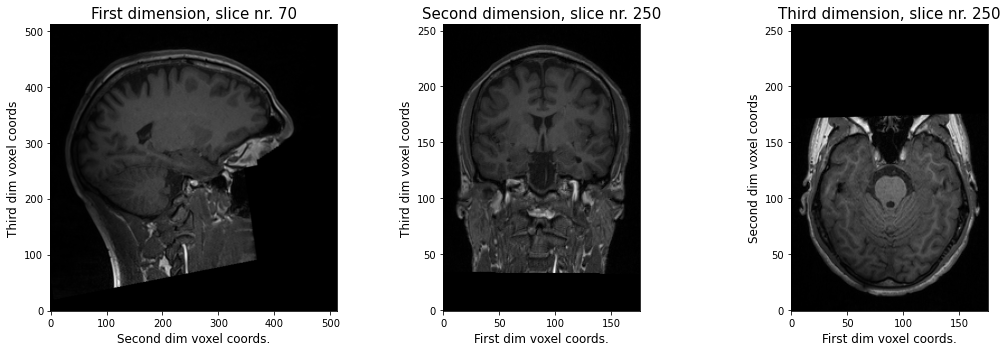

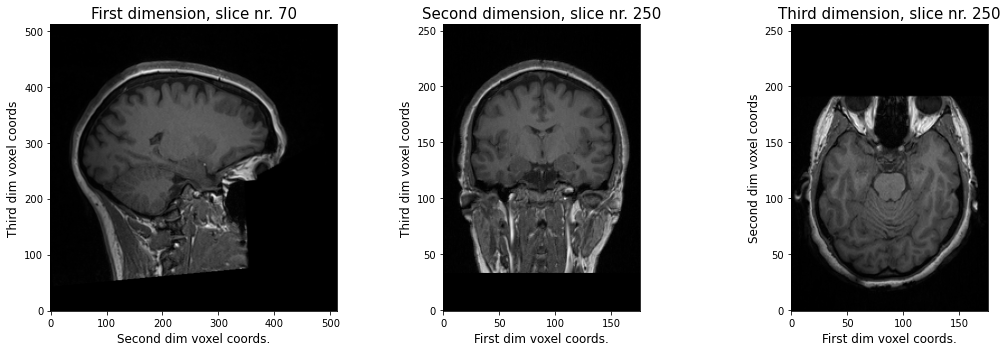

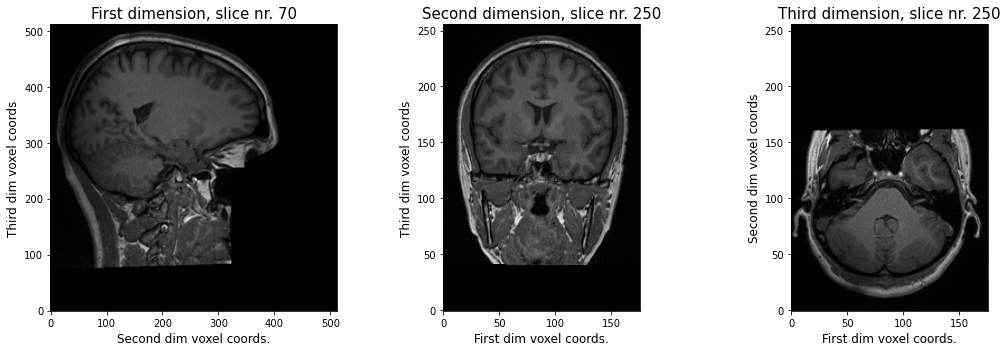

In [137]:
#Specify the particular path where the data that is wanted to be study is placed on your computer. 
data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
#data_folder = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen'
#data_folder = 'C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download'
Anatomical_representation (data_folder,[101,106,109])



The first step was to analyze the images available, in the plots above, the MRI (T1) of three subjects of the cohort can be seen. Apparently, in this images no differences can be appreciate, as all participants were healthy subjects, this is why an analysis of the different dataset (fMRI and EEG) was necessary.

# fMRI

## Single subject and single protocol file (eegfmriNF) analysis

To start with the analysis of the fMRI it was used the information of one subject and the data obtained when the subject has a combination of eeg and fmri neurofeedback while doing the task. 

Epi plot from fMRI mean image


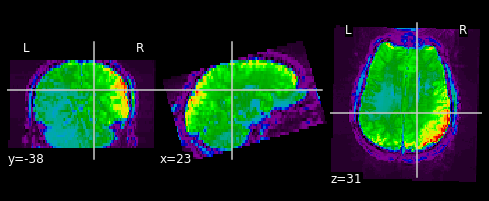

In [138]:
#subject_data = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen/sub-xp101/func/sub-xp101_task-eegfmriNF_bold.nii.gz'
subject_data = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project/sub-xp101/func/sub-xp101_task-eegfmriNF_bold.nii.gz'

fmri_img= nib.load(subject_data)
mean_img = image.mean_img(fmri_img)
mask = masking.compute_epi_mask(mean_img)

#After computing the mask and the mean image, fmri-img is rewritten in numpy format
fmri_img, affine, img = load_nifti(subject_data , return_img=True)

print('Epi plot from fMRI mean image')
plot_epi(mean_img);


### Task - Rest separation

Then, in order to examine the differences between task and rest events, the fMRI image of the first subject was split and averaged using the events table shown below:

In [139]:
#events_ = pd.read_table('C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen/task-eegfmriNF_events.tsv')
events_ = pd.read_table('/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project/task-eegfmriNF_events.tsv')


del events_['stim_file']

events=events_.replace({'Task-NF':'Task'})

events

,onset,duration,trial_type
0,2,20,Rest
1,22,20,Task
2,42,20,Rest
3,62,20,Task
4,82,20,Rest
5,102,20,Task
6,122,20,Rest
7,142,20,Task
8,162,20,Rest
9,182,20,Task


In the table above the different trials are specify, and the onset and duration of each trial are shown. This table was useful in order to split the slides, taking into account that the repetition time (tr) between images was 2s. 

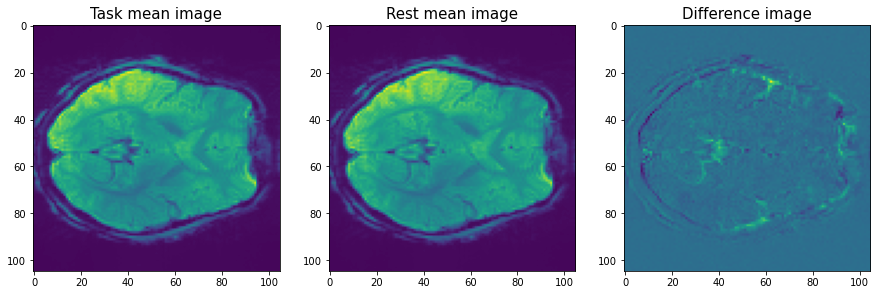

In [140]:
# Task and rest slides separated

fmri_rest=[]
fmri_rest_avg=[]
fmri_rest_todos=[]
fmri_task=[]
fmri_task_avg=[]
fmri_task_todos=[]
fmri_rest_todos_avg=np.zeros((106,106,32,10))
fmri_task_todos_avg=np.zeros((106,106,32,10))
count=0
count2=0
a=range(1,201,20)
for rest in a:
    fmri_rest_avg=fmri_img[:,:,:,rest+1:rest+9]
    fmri_rest_mean_avg=np.mean(fmri_rest_avg, axis=3)
    fmri_rest_todos_avg[:,:,:,count]=fmri_rest_mean_avg
    count+=1
    fmri_rest=fmri_img[:,:,:,rest:rest+10]
    if rest==1:
        fmri_rest_todos=fmri_rest
    else:
        fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)

for task in range(11,211,20):
    fmri_task_avg=fmri_img[:,:,:,task+1:task+9]
    fmri_task_mean_avg=np.mean(fmri_task_avg, axis=3)
    fmri_task_todos_avg[:,:,:,count2]=fmri_task_mean_avg
    count2+=1
    fmri_task=fmri_img[:,:,:,task:task+10]
    if task==11:
        fmri_task_todos=fmri_task
    else:
        fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
        
mean_img_rest_np=np.mean(fmri_rest_todos,axis=3)
mean_img_task_np=np.mean(fmri_task_todos,axis=3)
reference_image=mean_img_rest_np-mean_img_task_np

varx=slice(0, 105)
vary=slice(0, 105)
varz=14

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(mean_img_task_np[varx,vary,varz])
ax[0].set_title('Task mean image', fontsize=15)
ax[1].imshow(mean_img_rest_np[varx,vary,varz])
ax[1].set_title('Rest mean image', fontsize=15)
ax[2].imshow(reference_image[varx,vary,varz])
ax[2].set_title('Difference image', fontsize=15);


After splitting and plotting the images of task and rest, apparently not much difference could be appreciated. However, this little difference suggest that task and rest has not the same impact on the subject and it had to be studied deeply. 

Tho single voxels (__marked__ on the figure representation made below) were used in order to see the voxel value evolution and be able to compare visually differences between task and rest.

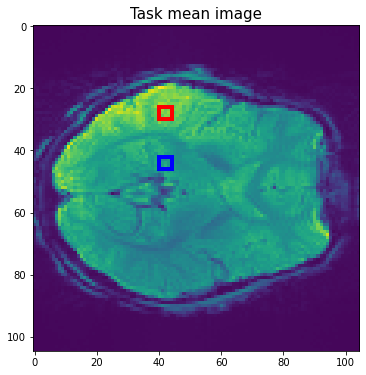

In [141]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mean_img_task_np[varx,vary,varz])
ax.set_title('Task mean image', fontsize=15)
rect = patches.Rectangle((40, 26), 4, 4, linewidth=4, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((40, 42), 4, 4, linewidth=4, edgecolor='b', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)
plt.show()

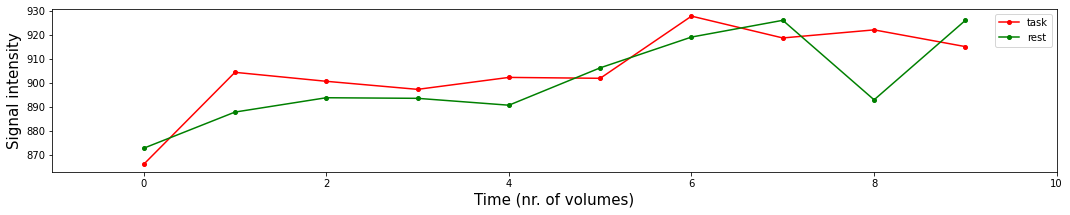

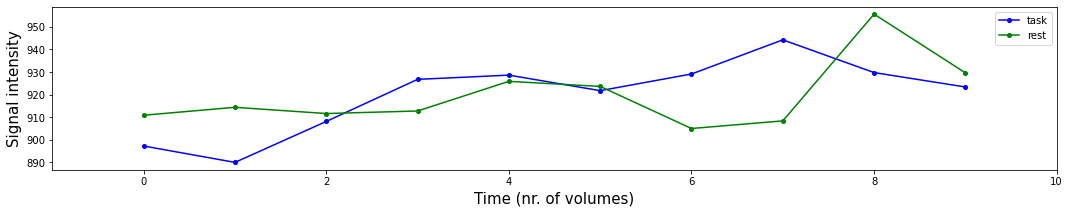

In [142]:
mid_vox_task = fmri_task_todos_avg[40, 26, 14, :]  
mid_vox_rest = fmri_rest_todos_avg[40, 26, 14, :] 

plt.figure(figsize=(18, 3))
plt.plot(mid_vox_task, 'o-', ms=4, color='r', label='task')
plt.plot(mid_vox_rest, 'o-', ms=4, color='g', label='rest')
plt.xlim(-1, mid_vox_task.size)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (nr. of volumes)', fontsize=15)
plt.legend()
plt.show()

mid_vox_task = fmri_task_todos_avg[40, 42, 14, :]  
mid_vox_rest = fmri_rest_todos_avg[40, 42, 14, :] 

plt.figure(figsize=(18, 3))
plt.plot(mid_vox_task, 'o-', ms=4, color='b', label='task')
plt.plot(mid_vox_rest, 'o-', ms=4, color='g', label='rest')
plt.xlim(-1, mid_vox_task.size)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (nr. of volumes)', fontsize=15)
plt.legend()
plt.show()

In the graphics above we can see the differences of the signal intensity for the two voxels and for the different events. Comparing them, we can observe that although they changes over the time, task and rest has more or less the same average signal intensity.

### Extracting regions of activation

Furthermore, the more relevant regions changes from active to rest were represented.

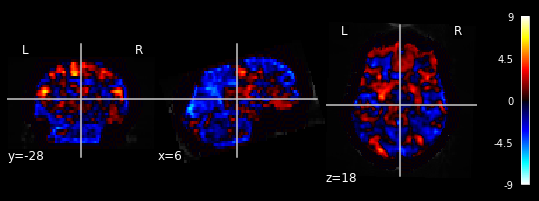

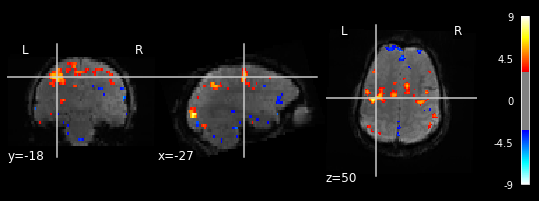

In [143]:
fmri_img = nib.load(subject_data)
mean_img = image.mean_img(fmri_img)
mask = masking.compute_epi_mask(mean_img)
fmri_img = image.clean_img(fmri_img, standardize=False)
fmri_img = image.smooth_img(fmri_img, 5.)

#events_ = pd.read_table('C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen/task-eegfmriNF_events.tsv')
events_ = pd.read_table('/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project/task-eegfmriNF_events.tsv')
del events_['stim_file']
events=events_.replace({'Task-NF':'Task'})

tr = 2  # repetition time of MRI scans is 2 seconds
n_scans = fmri_img.shape[3]  
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

hrf_model = 'spm'
X1 = make_first_level_design_matrix(frame_times, events, drift_model='Cosine',
                                    hrf_model=hrf_model)
fmri_glm = FirstLevelModel(signal_scaling=False, mask_img=mask, minimize_memory=False)
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=X1)

z_map = fmri_glm.compute_contrast('Task- Rest')
plotting.plot_stat_map(z_map, bg_img=mean_img);
plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=3.1)

In the figures above we can see that the more relevant changes from active to rest, in this first subject, is located in the primary motor cortex of the brain, which makes sense since the subject is doing an exercise of motor imaging that consist on moving the hand. Also, this activation is shown in the left hemisphere of the brain, think that reinforce the fact that the subject imagine the movement of right hand. 

(https://jbpe.sums.ac.ir/article_46458.html)

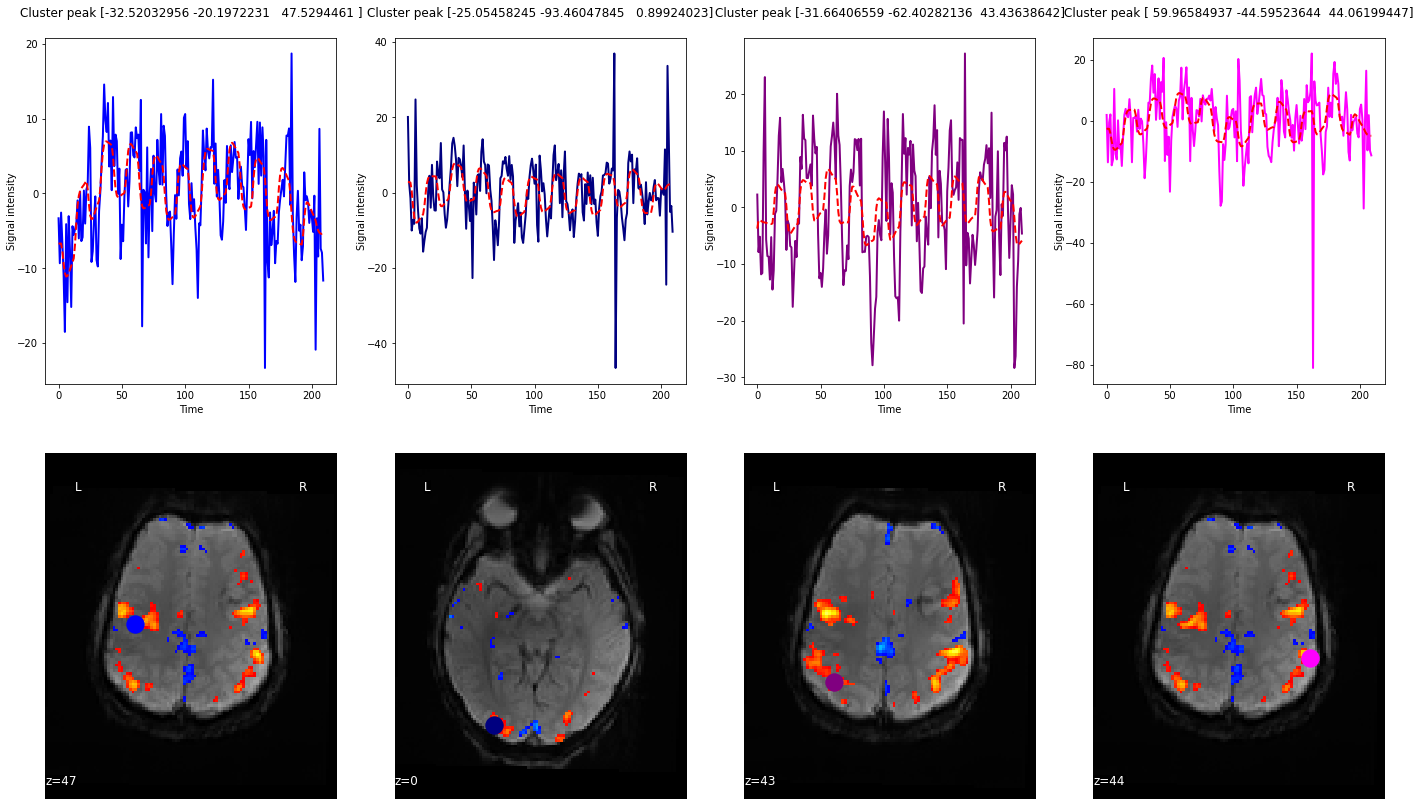

In [144]:
table = get_clusters_table(z_map, stat_threshold=3.1,
                           cluster_threshold=20).set_index('Cluster ID', drop=True)
# get the 4 largest clusters' max x, y, and z coordinates
coords = table.loc[range(1,5), ['X', 'Y', 'Z']].values
# extract time series from each coordinate
masker = input_data.NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(fmri_img)
# The predicted time series was also extracted with GLM, it is useful to assess the quality of the model fit.
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

# colors for each of the clusters
colors = ['blue', 'navy', 'purple', 'magenta']
# plot the time series and corresponding locations
fig1, axs1 = plt.subplots(2, 4)
for i in range(0, 4):
    # plotting time series
    axs1[0, i].set_title('Cluster peak {}\n'.format(coords[i]))
    axs1[0, i].plot(real_timeseries[:, i], c=colors[i], lw=2)
    axs1[0, i].plot(predicted_timeseries[:, i], c='r', ls='--', lw=2)
    axs1[0, i].set_xlabel('Time')
    axs1[0, i].set_ylabel('Signal intensity', labelpad=0)
    # plotting image below the time series
    roi_img = plotting.plot_stat_map(
        z_map, cut_coords=[coords[i][2]], threshold=3.1, figure=fig1,
        axes=axs1[1, i], display_mode='z', colorbar=False, bg_img=mean_img)
    roi_img.add_markers([coords[i]], colors[i], 300)
fig1.set_size_inches(24, 14)


__(FALTA COMPLETAR con expliación de lo que se esta haciendo)__

### Atlas and correlation matrix 

[NiftiMapsMasker.fit_transform] loading regions from /Users/juliagarciacornet/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[Memory]0.1s, 0.0min    : Loading resample_img...


/Users/juliagarciacornet/opt/anaconda3/envs/Neuroimatge/lib/python3.9/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


________________________________________resample_img cache loaded - 0.3s, 0.0min
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
(39, 39)


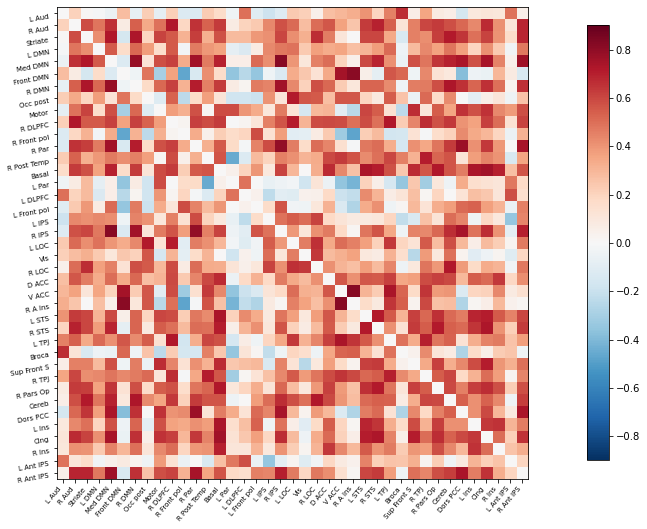

In [145]:
# Correlation matrix for the rest event

dataset = datasets.fetch_atlas_msdl() # Import atlas file
atlas_filename = dataset.maps
labels = dataset.labels

fmri_rest_todos=nib.Nifti1Image(fmri_rest_todos,affine)  # Tranform data to nifti files
fmri_task_todos=nib.Nifti1Image(fmri_task_todos,affine)  

masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5) # Create a mask

time_series = masker.fit_transform(fmri_rest_todos)
  
# Calculate the correlation matrix
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]


# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
fig = plt.figure(figsize=(10,10))
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=0.9, vmin=-0.9,axes=fig.gca())

print(correlation_matrix.shape)

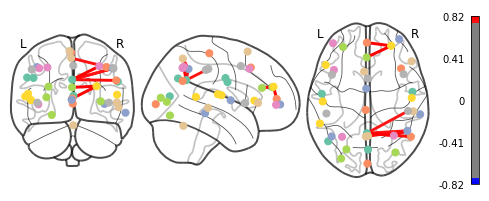

In [146]:
# Connectome map for the resting state

coords = dataset.region_coords

plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="99%", colorbar=True)

plotting.show()

[NiftiMapsMasker.fit_transform] loading regions from /Users/juliagarciacornet/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
[Memory]4.0s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
(106, 106, 32, 100)
(39, 39)


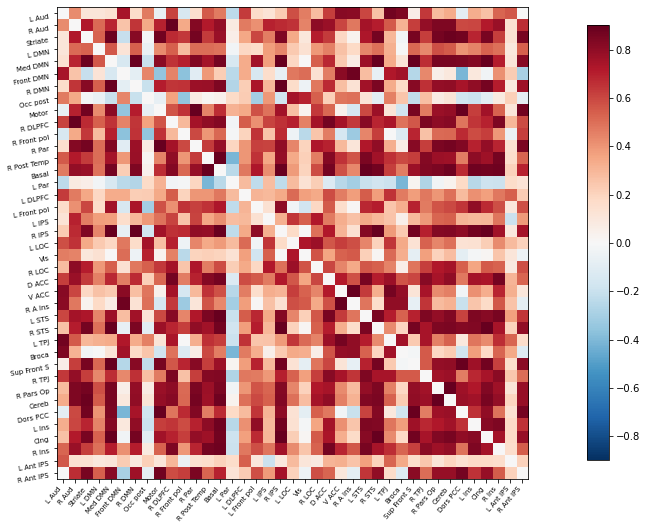

In [147]:
# Correlation matrix for the task event

time_series = masker.fit_transform(fmri_task_todos)

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
fig = plt.figure(figsize=(10,10))
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=0.9, vmin=-0.9,axes=fig.gca())

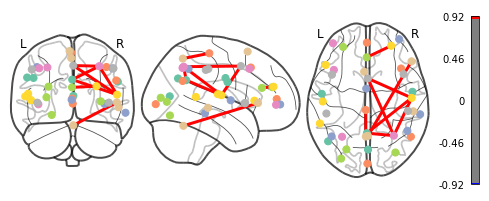

In [148]:
# Connectome map for the task state

coords = dataset.region_coords

plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="99%", colorbar=True)

plotting.show()

### Classification report

In [10]:
X=np.zeros((200,11236))
Y=np.zeros((200,1))
for i in range(0,100,1):
    a=fmri_rest_todos[:,:,15,i]
    X[i,:]=a.flatten()
    Y[i,0]=0
for i in range(0,100,1):
    a=fmri_task_todos[:,:,15,i]
    X[i+100,:]=a.flatten()
    Y[i+100,0]=1
    
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.35)

n_components = 100

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

y_train = column_or_1d(np.ravel(y_train), warn=True)
y_test = column_or_1d(np.ravel(y_test), warn=True)

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm = svm.fit(X_train_pca, y_train)

target_names=np.array(['Rest', 'Task'])
n_classes=2
print("\n")
print("Support Vector machine")
y_pred_svm = svm.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print(confusion_matrix(y_test, y_pred_svm, labels=(0,1)))
numerito=accuracy_score(y_test,y_pred_svm)*100
print("SVC accuracy: {:.3f}".format(numerito))
print("\n")

print("Linear Discriminant Analysis")
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_pca, y_train)
y_pred_lda = lda.predict(X_test_pca)
print(classification_report(y_test, y_pred_lda, target_names=target_names))
print(confusion_matrix(y_test, y_pred_lda, labels=(0,1)))
numerito=accuracy_score(y_test,y_pred_lda)*100
print("LDA accuracy: {:.3f}".format(numerito))
print("\n")

print("DecisionTreeClassifier")
dt = DecisionTreeClassifier()
dt = dt.fit(X_train_pca, y_train)
y_pred_dt = dt.predict(X_test_pca)
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print(confusion_matrix(y_test, y_pred_dt, labels=(0,1)))
numerito=accuracy_score(y_test,y_pred_dt)*100
print("Decission Tree accuracy: {:.3f}".format(numerito))
print("\n")

print("Artificial neural network")
ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
ann.fit(X_train_pca, y_train)
y_pred_ann = ann.predict(X_test_pca)
print(classification_report(y_test, y_pred_ann, target_names=target_names))
print(confusion_matrix(y_test, y_pred_ann, labels=(0,1)))
numerito=accuracy_score(y_test,y_pred_ann)*100
print("ANN accuracy: {:.3f}".format(numerito))

Extracting the top 100 eigenfaces from 130 faces


Support Vector machine
              precision    recall  f1-score   support

        Rest       1.00      0.05      0.10        38
        Task       0.47      1.00      0.64        32

    accuracy                           0.49        70
   macro avg       0.74      0.53      0.37        70
weighted avg       0.76      0.49      0.35        70

[[ 2 36]
 [ 0 32]]
SVC accuracy: 48.571


Linear Discriminant Analysis
              precision    recall  f1-score   support

        Rest       0.86      0.82      0.84        38
        Task       0.79      0.84      0.82        32

    accuracy                           0.83        70
   macro avg       0.83      0.83      0.83        70
weighted avg       0.83      0.83      0.83        70

[[31  7]
 [ 5 27]]
LDA accuracy: 82.857


DecisionTreeClassifier
              precision    recall  f1-score   support

        Rest       0.82      0.71      0.76        38
        Task       0.70    

__(FALTA COMPLETAR con expliación de lo que se esta haciendo)__

## All subjects and protocol files analysis

### Task - Rest analysis

### Atlas study

### Classification report

#### Individual analysis of the different models

In [11]:
def Classificationbuilder (data_folder,subject_code,fildd,n_components,ANNlayers,model_code):
     for i in  subject_code:
        print("Subject analyzed: {:.3f}".format(i))
        subject_folder='/sub-xp'
        String_contrinuation1='/func/sub-xp'
        String_contrinuation2=fildd
        subject_codee=str(i)
        
        subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
        fmri_img, affine, img = load_nifti(subject_data , return_img=True)
        
        fmri_rest=[]
        fmri_rest_todos=[]
        
        if fildd=='_task-motorloc_bold.nii.gz':
            r1=range(1,161,20)
            r2=range(11,171,20)
        
        else: 
            r1=range(1,201,20)
            r2=range(11,211,20)
        
        for rest in r1:
            fmri_rest=fmri_img[:,:,:,rest:rest+10]
            if rest==1:
                fmri_rest_todos=fmri_rest
            else:
                fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)
        fmri_task=[]
        fmri_task_todos=[]

        for task in r2:
            fmri_task=fmri_img[:,:,:,task:task+10]
            if task==11:
                fmri_task_todos=fmri_task
            else:
                fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
        
        
        if fildd=='_task-motorloc_bold.nii.gz':
            X=np.zeros((160,11236))
            Y=np.zeros((160,1))
            for i in range(0,80,1):
                a=fmri_rest_todos[:,:,15,i]
                X[i,:]=a.flatten()
                Y[i,0]=0
            for i in range(0,80,1):
                a=fmri_task_todos[:,:,15,i]
                X[i+80,:]=a.flatten()
                Y[i+80,0]=1
            
        else:     
            X=np.zeros((200,11236))
            Y=np.zeros((200,1))
            for i in range(0,100,1):
                a=fmri_rest_todos[:,:,15,i]
                X[i,:]=a.flatten()
                Y[i,0]=0
            for i in range(0,100,1):
                a=fmri_task_todos[:,:,15,i]
                X[i+100,:]=a.flatten()
                Y[i+100,0]=1
            
        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.35)
        

        pca = PCA(n_components=n_components, svd_solver='randomized',
                  whiten=True).fit(X_train)
        
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        y_train = column_or_1d(np.ravel(y_train), warn=True)
        y_test = column_or_1d(np.ravel(y_test), warn=True)

        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
        svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
        svm = svm.fit(X_train_pca, y_train)
        
        target_names=np.array(['Rest', 'Task'])
        n_classes=2
        
        y_pred_svm = svm.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_svm)*100
        print("SVC accuracy: {:.3f}%".format(numerito))
        
        lda = LinearDiscriminantAnalysis()
        lda = lda.fit(X_train_pca, y_train)
        y_pred_lda = lda.predict(X_test_pca)

        numerito=accuracy_score(y_test,y_pred_lda)*100
        print("LDA accuracy: {:.3f}%".format(numerito))
        
        dt = DecisionTreeClassifier()
        dt = dt.fit(X_train_pca, y_train)
        y_pred_dt = dt.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_dt)*100
        print("DT accuracy: {:.3f}%".format(numerito))
        
        ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(ANNlayers,), random_state=1)
        ann.fit(X_train_pca, y_train)
        y_pred_ann = ann.predict(X_test_pca)
        numerito=accuracy_score(y_test,y_pred_ann)*100
        print("ANN accuracy: {:.3f}%".format(numerito))
        print("\n")


In [13]:
#data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
data_folder = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen'

##### EEG - fMRI 

In [14]:
fild_to_study='_task-eegfmriNF_bold.nii.gz'
subject_code=[101,102,103,104,105,106,107,108,109,110]
Classificationbuilder (data_folder,subject_code,fild_to_study,100,150,101)

Subject analyzed: 101.000
SVC accuracy: 52.857%
LDA accuracy: 84.286%
DT accuracy: 70.000%
ANN accuracy: 82.857%


Subject analyzed: 102.000
SVC accuracy: 71.429%
LDA accuracy: 75.714%
DT accuracy: 62.857%
ANN accuracy: 72.857%


Subject analyzed: 103.000
SVC accuracy: 64.286%
LDA accuracy: 62.857%
DT accuracy: 51.429%
ANN accuracy: 64.286%


Subject analyzed: 104.000
SVC accuracy: 74.286%
LDA accuracy: 75.714%
DT accuracy: 60.000%
ANN accuracy: 74.286%


Subject analyzed: 105.000
SVC accuracy: 77.143%
LDA accuracy: 74.286%
DT accuracy: 64.286%
ANN accuracy: 77.143%


Subject analyzed: 106.000
SVC accuracy: 54.286%
LDA accuracy: 75.714%
DT accuracy: 55.714%
ANN accuracy: 77.143%


Subject analyzed: 107.000
SVC accuracy: 71.429%
LDA accuracy: 81.429%
DT accuracy: 75.714%
ANN accuracy: 80.000%


Subject analyzed: 108.000
SVC accuracy: 75.714%
LDA accuracy: 72.857%
DT accuracy: 60.000%
ANN accuracy: 75.714%


Subject analyzed: 109.000
SVC accuracy: 68.571%
LDA accuracy: 71.429%
DT accurac

##### Motorloc

In [21]:
fild_to_study='_task-motorloc_bold.nii.gz'
subject_code=[101,102,103,104,105,106,107,108,109,110]
Classificationbuilder (data_folder,subject_code,fild_to_study,100,150,101)

Subject analyzed: 101.000
SVC accuracy: 78.571%
LDA accuracy: 80.357%
DT accuracy: 62.500%
ANN accuracy: 75.000%


Subject analyzed: 102.000
SVC accuracy: 71.429%
LDA accuracy: 71.429%
DT accuracy: 62.500%
ANN accuracy: 75.000%


Subject analyzed: 103.000
SVC accuracy: 82.143%
LDA accuracy: 82.143%
DT accuracy: 76.786%
ANN accuracy: 80.357%


Subject analyzed: 104.000
SVC accuracy: 75.000%
LDA accuracy: 75.000%
DT accuracy: 73.214%
ANN accuracy: 73.214%


Subject analyzed: 105.000
SVC accuracy: 48.214%
LDA accuracy: 71.429%
DT accuracy: 64.286%
ANN accuracy: 69.643%


Subject analyzed: 106.000
SVC accuracy: 87.500%
LDA accuracy: 87.500%
DT accuracy: 73.214%
ANN accuracy: 89.286%


Subject analyzed: 107.000
SVC accuracy: 87.500%
LDA accuracy: 89.286%
DT accuracy: 80.357%
ANN accuracy: 85.714%


Subject analyzed: 108.000
SVC accuracy: 87.500%
LDA accuracy: 87.500%
DT accuracy: 76.786%
ANN accuracy: 87.500%


Subject analyzed: 109.000
SVC accuracy: 94.643%
LDA accuracy: 94.643%
DT accurac

# EEG

## Importing data

In [8]:
data_raw=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr')

Extracting parameters from C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr...
Setting channel info structure...


In [2]:
data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr',preload=True)

Extracting parameters from C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr...
Setting channel info structure...
Reading 0 ... 67387  =      0.000 ...   336.935 secs...


C:\Users\Alex\AppData\Local\Temp\ipykernel_21896\2777862424.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr',preload=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_21896\2777862424.py:1: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr',preload=True)


## Visualizing the loaded data

In [3]:
%matplotlib tk 
#for some reason this is needed for the data to plot properly

In [ ]:
data_raw.plot()

In [ ]:
data.plot()

## Further Preprocessing

### Filters & Reference

In [4]:
data_filt=data.copy().load_data().filter(0.1,30)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 sec)



In [5]:
for i in [20,22,24,26,34,40,42,48]:
    print(data.ch_names[i])
#names of the reference channels of the EEG used by the authors in their laplacian filter

FC1
CP1
FC5
CP5
C1
FC3
CP3
C5


In [6]:
data_reref=data_filt.copy().set_eeg_reference(ref_channels= ["FC1","CP1","FC5","CP5","C1","FC3","CP3","C5"])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


### Events

In [7]:
events=mne.events_from_annotations(data_reref)
events 

Used Annotations descriptions: ['New Segment/', 'Pulse Artifact/R', 'Response/R128', 'Stimulus/S  1', 'Stimulus/S 99', 'TPULSE/TEND', 'TPULSE/TPEAK', 'TPULSE/TSTART']


(array([[    0,     0, 99999],
        [ 2230,     0,  1128],
        [ 2249,     0, 10001],
        ...,
        [67030,     0,  1128],
        [67075,     0, 10001],
        [67227,     0, 10001]]),
 {'New Segment/': 99999,
  'Pulse Artifact/R': 10001,
  'Response/R128': 1128,
  'Stimulus/S  1': 1,
  'Stimulus/S 99': 99,
  'TPULSE/TEND': 10002,
  'TPULSE/TPEAK': 10003,
  'TPULSE/TSTART': 10004})

In [9]:
#Create a new channel called stimulation (STI) needed to add the events
stim=mne.create_info(['STI'],200,['stim'])
stim_raw=mne.io.RawArray(np.zeros([1,67388]),stim)
data_reref.load_data().add_channels([stim_raw],force_update_info=True)
data_reref.ch_names[-1]

Creating RawArray with float64 data, n_channels=1, n_times=67388
    Range : 0 ... 67387 =      0.000 ...   336.935 secs
Ready.


'STI'

In [10]:
data_reref.add_events(events[0],stim_channel='STI',replace=True) #add the events to the data

## Epochs

In [11]:
event_id = {'task':1,'rest':99}
tmin = 2  # start of each epoch 
tmax = 18  # end of each epoch 
baseline = (2, 3) 

In [12]:
reject_criteria = dict(eeg=600e-5)      
picks = mne.pick_types(data_reref.info, meg=False, eeg=True, stim=False, misc=True,
                       include=[])

In [13]:
epochs = mne.Epochs(data_reref, events[0], event_id, tmin, tmax, picks=picks, proj=False,
                    baseline=baseline, reject=reject_criteria)

Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)


In [14]:
epochs.plot()

Using data from preloaded Raw for 15 events and 3201 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 3201 original time points ...
Using qt as 2D backend.
Opening epochs-browser...
Using data from preloaded Raw for 15 events and 3201 original time points ...
Using data from preloaded Raw for 1 events and 3201 original time points ...
Using data from preloaded Raw for 1 events and 3201 original time points ...
Using data from preloaded Raw for 1 events and 3201 original time points ...
Using data from preloaded Raw for 1 events and 3201 original time points ...
Using data from preloaded Raw for 1 events and 3201 original time points ...
Using data from preloaded Raw for 1 events and 3201 original time points ...
Using data from preloaded Raw for 1 events and 3201 original time points ...
Using data from preloaded Raw for 1 events and 3201 original time points ...
Using data from preloaded Raw for 6 events and 3201 original time points ...
Us

## Evoked potential

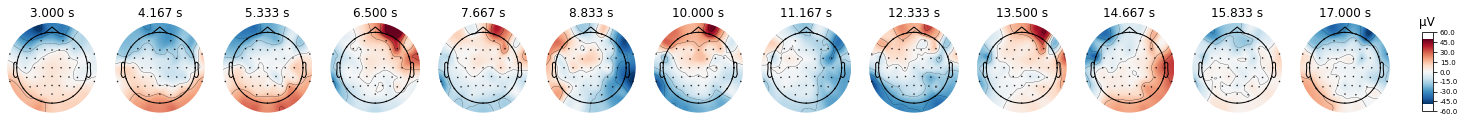

In [15]:
evoked = epochs['task'].average() #mean of the epochs to get the evoked response
evoked.plot(time_unit='s', gfp=True) #plot of the evoked response
evoked.plot_topomap(times=np.linspace(3, 17, 13), ch_type='eeg',time_unit='s') #topomap

## A new approach

In [16]:
epochs2= mne.make_fixed_length_epochs(data_reref.copy().crop(tmin=32, tmax=51))

Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated


In [17]:
epochs2.load_data().plot()

Using data from preloaded Raw for 19 events and 200 original time points ...
0 bad epochs dropped
Opening epochs-browser...


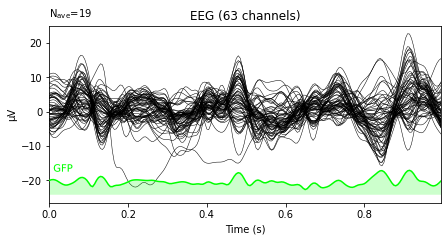

In [18]:
evoked2 = epochs2.average() #mean of the epochs to get the evoked response
evoked2.plot(time_unit='s', gfp=True) #plot of the evoked response